## Exploratory Data Analysis

### Getting Started

In [98]:
# Loading modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import os
from helper import load_img_data, plot_images
import missingno as msno

In [24]:
# Getting the current working directory
os.getcwd()

'/Users/brandonjenkins/PycharmProjects/machine-learning-projects/Melanoma'

In [25]:
# Loading in the data
X_train, y_train, X_test = load_img_data() # Image data
train_meta = pd.read_csv("data/train.csv") # Meta data
test_meta = pd.read_csv("data/test.csv") # Meta data

### Target 

In [4]:
# Distribution of our target variable
print(f"Malignant: {np.sum(y_train)} Benign: {len(y_train) - np.sum(y_train)}")

Malignant: 584 Benign: 32542


As expected there is a class imbalance between benign and malignant. Two ideas to remedy this are
- `weighting the classes`
- `data augmentation on the malignant images to create more samples`

Data augmentation is pretty similar to oversampling/synthetic method.

### Images

Note: I previously scaled all the images down to 60x60 to make the problem more tractable. 

In [20]:
# Taking a look at some malignant and benign moles
malignant = y_train == 1
malignant_x = X_train[malignant][15:20]
malignant_y = y_train[malignant][15:20]
benign_x = X_train[~malignant][15:20]
benign_y = y_train[~malignant][15:20]
mole_img = np.vstack([malignant_x, benign_x])
mole_target = np.vstack([malignant_y, benign_y]).flatten()

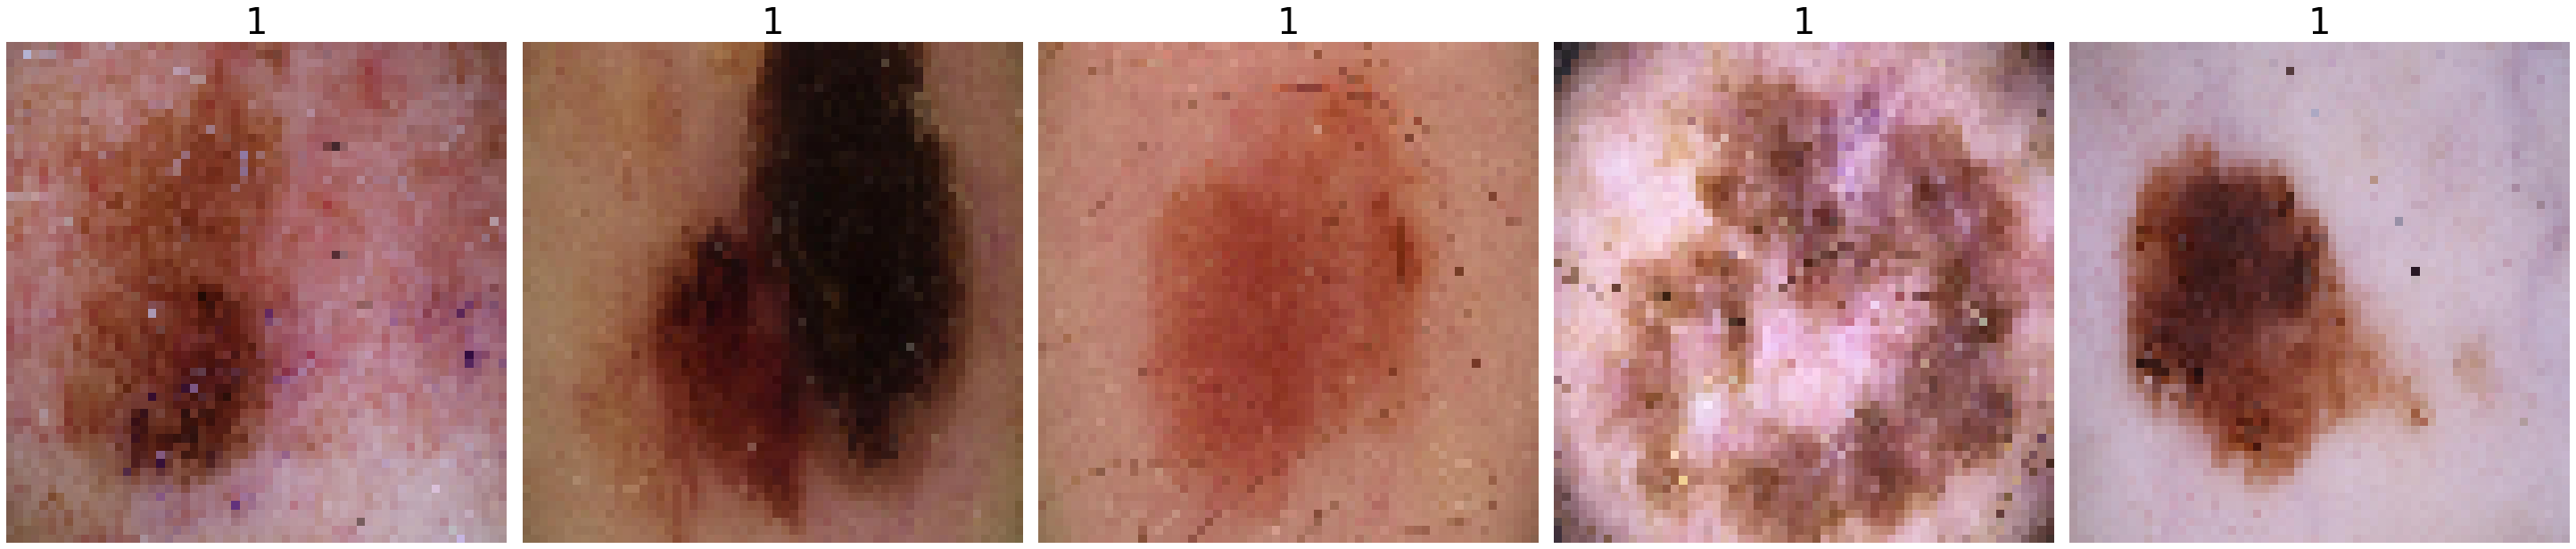

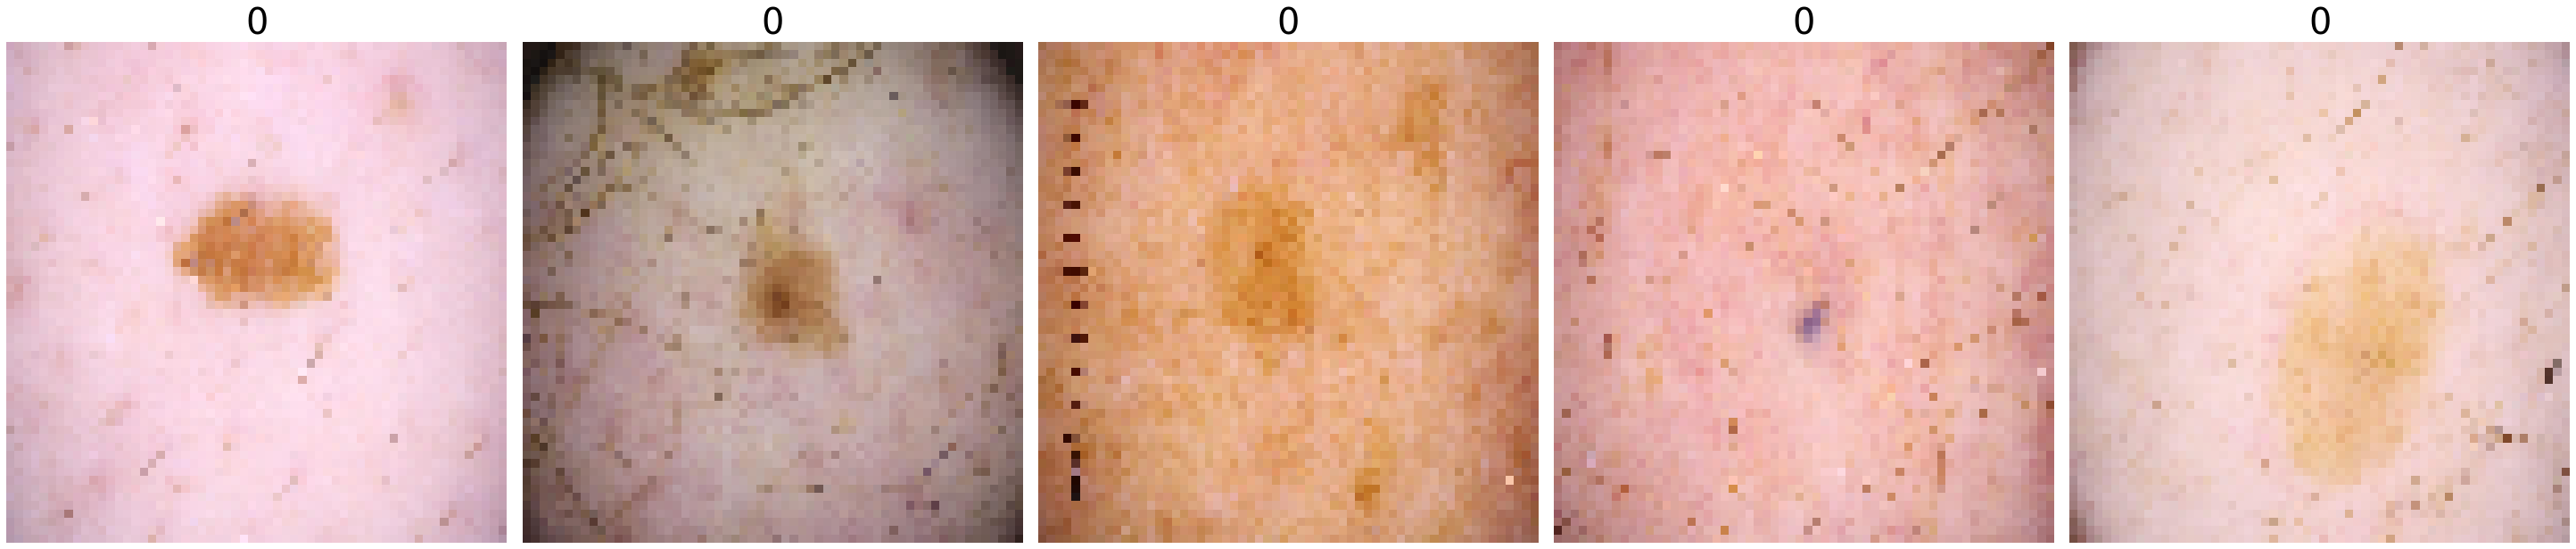

In [21]:
# Visualizing what the different moles look like
plot_images(malignant_x, malignant_y, 1, 5, figsize=(40, 40)) # malignant
plot_images(benign_x, benign_y, 1, 5, figsize=(40, 40)) # benign

Using the ABCDE rule to identify melanoma:

- Asymmetry 
- Border - ragged, notched, blurred
- Color - uneven
- Diameter - typically > 6mm
- Evolving 

We can start to understand the physical characteristics of malignant moles. The moles in the top row are all asymmetrical, have ragged borders, and uneven color. It's hard to determin the actual size and whether or not the moles are evolving. 

Note - I personally handpicked these malignant images, so before you go diagnosing your friends moles understand that not all cases of melanoma are this easy to distinguish!

## Meta data

In [28]:
# Taking a look at the meta data
train_meta.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


image_name                         0
patient_id                         0
sex                               65
age_approx                        68
anatom_site_general_challenge    527
diagnosis                          0
benign_malignant                   0
target                             0
dtype: int64

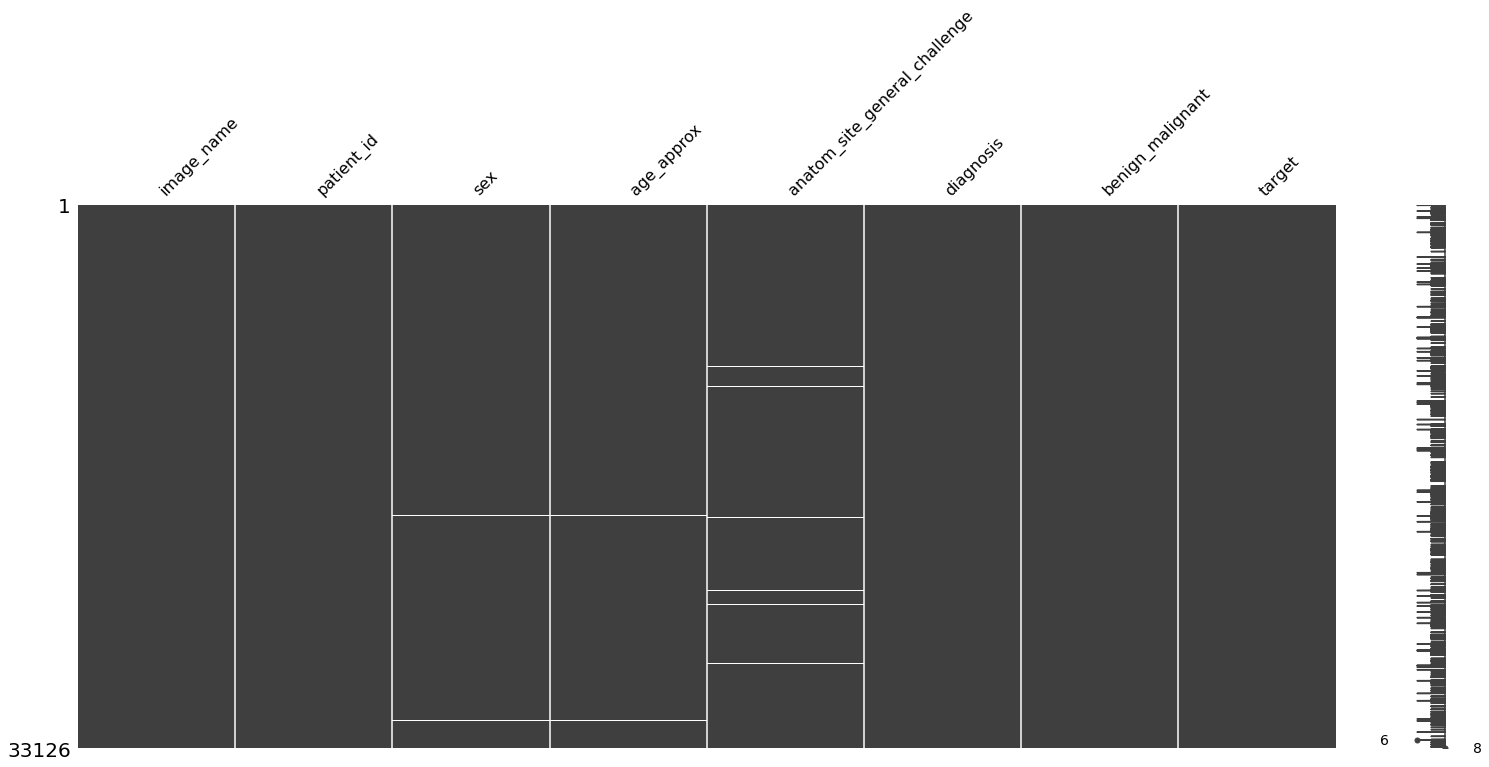

In [71]:
# Any missing data?
msno.matrix(train_meta)
train_meta.isnull().sum()

It appears that when sex is missing, so is the age approximation. Let's look at the actual data, where this criteria is true. I am thinking about replacing the nas with `missing` for sex and anatom_site_general_challenge features. For the age_approx column I am going to impute with the mean for the given target value for the training set. I dont want there to be data leakage. I will take care of all the preprocessing in another notebook.

In [115]:
# Lets look at the missing data further
train_meta[train_meta['sex'].isnull()].head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
38,ISIC_0088137,IP_5205991,NaN,NaN,lower extremity,unknown,benign,0
384,ISIC_0229600,IP_5205991,NaN,NaN,upper extremity,unknown,benign,0
750,ISIC_0331124,IP_9835712,NaN,NaN,torso,unknown,benign,0
829,ISIC_0353280,IP_9835712,NaN,NaN,upper extremity,unknown,benign,0
1687,ISIC_0608625,IP_5205991,NaN,NaN,lower extremity,unknown,benign,0


### Patient Id

In [122]:
# Lets look at how many images per patient
print(train_meta['patient_id'].value_counts().describe())

count    2056.000000
mean       16.111868
std        15.674491
min         2.000000
25%         5.000000
50%        12.000000
75%        22.000000
max       115.000000
Name: patient_id, dtype: float64


On average a patient has 16 images. The max being 115 and the min being 2. From previous exploration, the patient_ids are unique to to the training data. Test data has different patient_ids that are not found in training set.

Text(0.5, 1.0, 'Percentage of melanoma among patients with at least one cancerous mole.')

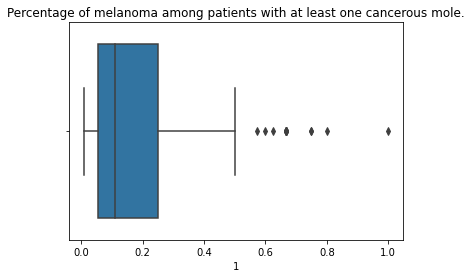

In [147]:
# For patients that have at least one cancerous mole, what is the percentage of cancer among all their moles?
mel_patientid = train_meta.loc[train_meta['target'] == 1, 'patient_id']
patientid_grouped = train_meta[train_meta['patient_id'].isin(mel_patientid)]
patientid_count = patientid_grouped.groupby(['patient_id', 'target']).size()
patientid_df = (patientid_count / patientid_grouped.groupby('patient_id').size()).unstack().loc[:, 1]

# Plotting the percentage of cancerous moles among patients with at least one melanoma.
sns.boxplot(patientid_df.sort_values(ascending=False))
plt.title("Percentage of melanoma among patients with at least one cancerous mole.")

For patients that have melanoma, the majority of their moles are still benign. 

### Sex

sex     target
female  0         0.986234
        1         0.013766
male    0         0.978689
        1         0.021311
dtype: float64

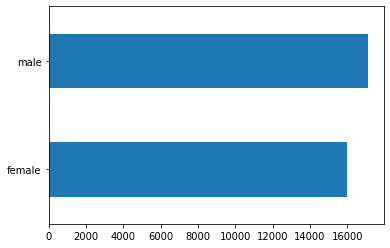

In [53]:
# Looking at sex
train_meta['sex'].value_counts(ascending=True).plot(kind="barh")
sex_grouped = train_meta.groupby(['sex', 'target'])
sex_grouped.size() / train_meta.groupby('sex').size()

### Location of moles


anatom_site_general_challenge  target
head/neck                      0         0.960108
                               1         0.039892
lower extremity                0         0.985268
                               1         0.014732
oral/genital                   0         0.967742
                               1         0.032258
palms/soles                    0         0.986667
                               1         0.013333
torso                          0         0.984743
                               1         0.015257
upper extremity                0         0.977724
                               1         0.022276
dtype: float64

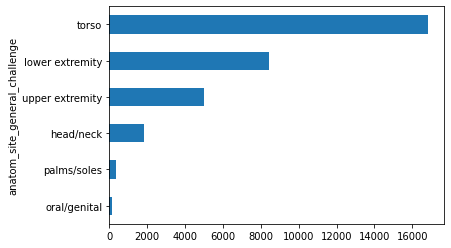

In [56]:
# Looking at anatom_site_general_challenge according to kaggle this is the location of the image
loc_count = train_meta.groupby('anatom_site_general_challenge').size()
loc_grouped = train_meta.groupby(['anatom_site_general_challenge', 'target'])
loc_count.sort_values().plot(kind="barh")
loc_grouped.size() / loc_count

Looks like despite the location on the body the probability of moles being melanoma is less than 4%.

However, `head/neck` and `oral/genital` have slightly higher probabilities, 3.98% and 3.22% respectively. This could be due to random chance.

Based off this information it looks like this feature could add valuable predictive power to the model.

Note - probably need to split the validation set to include all the different locations.

### Approximate Age

          count       mean        std   min   25%   50%   75%   max
target                                                             
0       32474.0  48.703424  14.290930   0.0  40.0  50.0  60.0  90.0
1         584.0  58.133562  16.200692  15.0  45.0  60.0  70.0  90.0


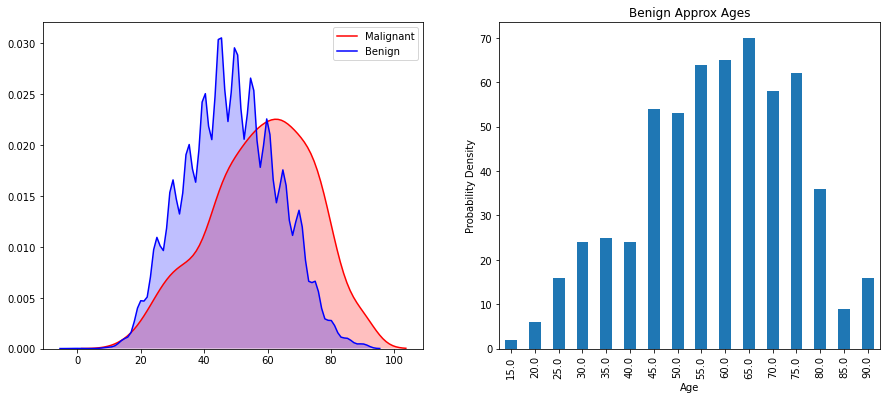

<Figure size 432x288 with 0 Axes>

In [111]:
# Distribution of age feature
mal_age = train_meta.loc[train_meta['target'] == 1, 'age_approx']
ben_age = train_meta.loc[train_meta['target'] == 0, 'age_approx']

# Subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Density plot
sns.kdeplot(mal_age, color="r", shade=True, Label="Malignant", ax=ax[0])
sns.kdeplot(ben_age, color='b', shade=True, Label="Benign", ax=ax[0])
plt.xlabel("Age")
plt.ylabel("Probability Density")

# Bar plot
plt.figure()
mal_age.value_counts().sort_index().plot(kind="bar", ax=ax[1])
ax[1].set_title("Benign Approx Ages")

print(train_meta.groupby('target')['age_approx'].describe()) # summary statistics

The distribution of age for people that have benign moles is pretty wild looking. This is probably due to the ages being binned into every 5 years already (see chart on right) and there being a smaller sample size. The ages are indeed approximated. The means for the two groups appear to be different. Malignant has a mean age of 58.1 years old and benign is 48.7. Again, this could be due to random chance, but not likely. It makes sense. The older the individual, the greater the likelihood that they could get genetic mutations that cause cancer. 